**Approach**

We finetuned Paligemma, a 3-Billion parameter vision-language model developed by Google, using LoRA to make the training process more efficient. We framed the task as a multiple-choice-question answering problem, and achieved an accuracy of ~86% on the test set.

Final training was done on the ARC cluster with a batch size of 8 and a 1e-5 learning rate which we found, experimentally, to give the best results. Inference was done on Ziheng's 4070 and the TALC cluster.

This notebook contains analysis and inspection of predictions made by our model on the test set. To aid our analysis, we generated csv files containing the predictions of the trained model. These CSVs contain the filename, expected class, and predicted class. The script for generating these predictions is included in our sources. 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import re

In [2]:
# TEST_PATH = r"/work/TALC/enel645_2024f/garbage_data/CVPR_2024_dataset_Test"
TEST_PATH = r"/Users/tomi_owolabi/garbage_data/garbage_data/CVPR_2024_dataset_Test"

In [3]:
#Setup

all_predictions = pd.read_csv("predictions.csv")
class_names = sorted(["blue", "green", "black", "ttr"])
name_to_idx = {name: idx for idx, name in enumerate(class_names)}
all_predictions["predicted"] = all_predictions["predicted"].replace("other", "ttr") #We replaced TTR with 'other' while making predictions
all_predictions['num_labels'] = all_predictions['label'].map(name_to_idx).fillna("4").astype(int)
all_predictions["num_preds"] = all_predictions['predicted'].map(name_to_idx).fillna("4").astype(int)

misclassified_df = all_predictions[all_predictions['label'] != all_predictions['predicted']]
all_predictions.columns

Index(['path', 'predicted', 'label', 'num_labels', 'num_preds'], dtype='object')

In [4]:
all_predictions.describe()

num_labels    num_preds
count  3431.000000  3431.000000
mean      1.526960     1.470417
std       1.073027     1.076484
min       0.000000     0.000000
25%       1.000000     1.000000
50%       1.000000     1.000000
75%       2.000000     2.000000
max       3.000000     3.000000

In [5]:
class_names.append("out-of-domain") # We observed occasional spurious predictions from Paligemma

**ACCURACY**

In [6]:
correct_classifications = all_predictions[all_predictions["label"]==all_predictions["predicted"]]
accuracy = len(correct_classifications)/len(all_predictions)
print (f"ACCURACY: {accuracy:03f}")

ACCURACY: 0.861556


[0 1 2 3]


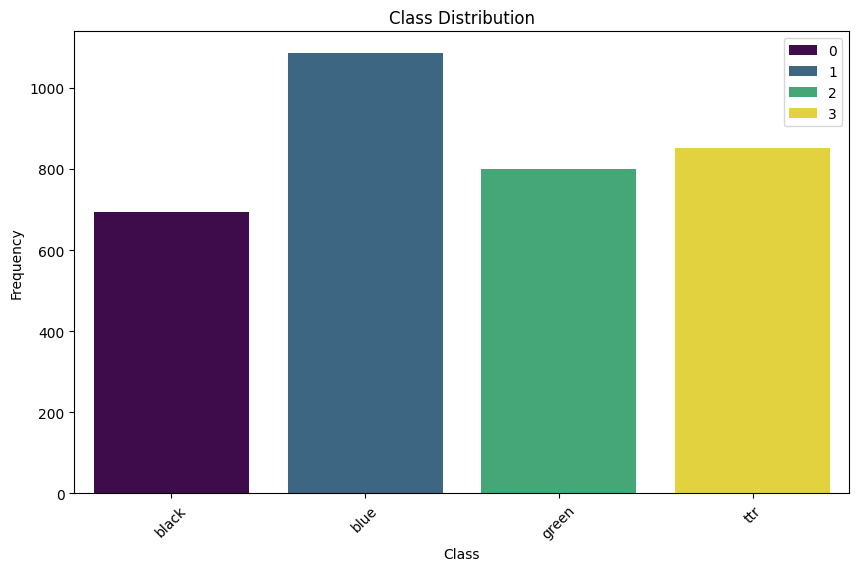

In [6]:
def plot_class_distribution(y_true, class_names):
    """
    Plots the distribution of each class in the dataset.
    """
    unique, counts = np.unique(y_true, return_counts=True)
    print(unique)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[class_names[i] for i in unique], y=counts, palette="viridis", hue=unique)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(all_predictions["num_labels"], class_names)

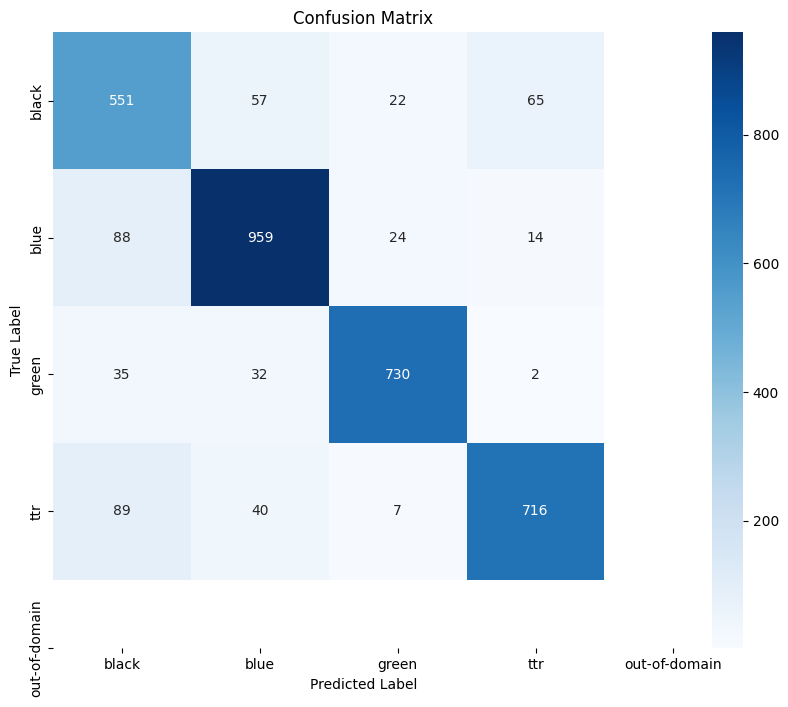

In [7]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(all_predictions['num_labels'], all_predictions['num_preds'], class_names=class_names)

In [8]:
precision, recall, fscore, support = score(all_predictions["num_labels"], all_predictions["num_preds"])
metrics_df = pd.DataFrame({
    'Class': [f'{class_names[i]}'.upper() for i in range(len(precision))], 
    'Precision': precision,
    'Recall': recall,
    'F-Score': fscore,
})
print(metrics_df.to_string(index=False))


Class  Precision   Recall  F-Score
BLACK   0.722149 0.792806 0.755830
 BLUE   0.881434 0.883871 0.882651
GREEN   0.932312 0.913642 0.922882
  TTR   0.898369 0.840376 0.868405


In [9]:
def to_description(file_name):
    file_name_no_ext, _ = os.path.splitext(file_name)
    text = file_name_no_ext.replace('_', ' ')
    text_without_digits = re.sub(r'\d+', '', text)
    return text_without_digits

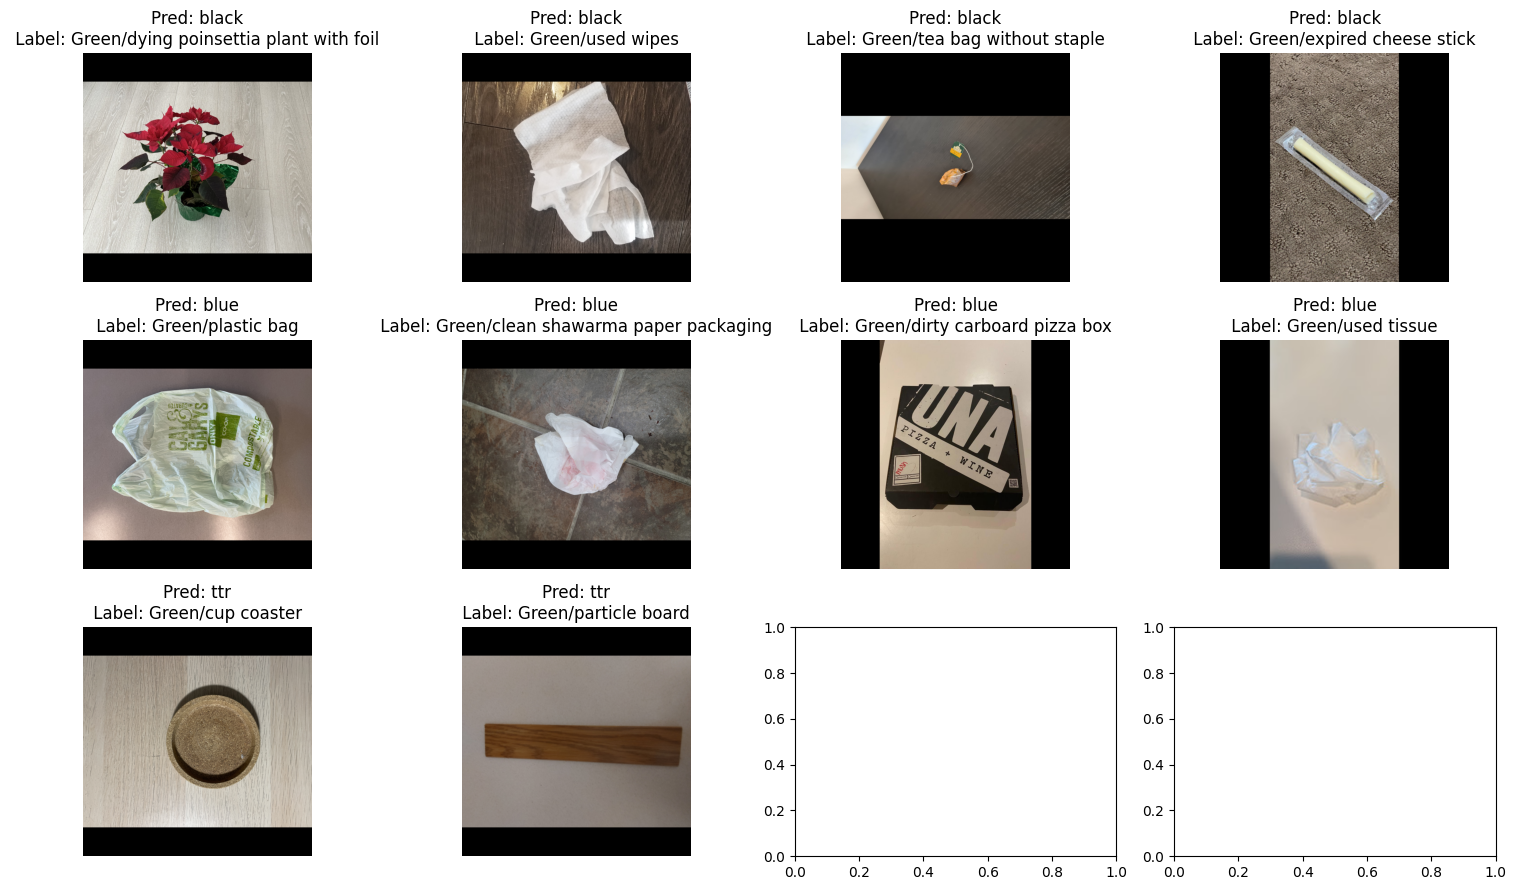

In [10]:
def show_misclassified_examples(df, active_label="green", label_column='label', predicted_column='predicted', image_path_column='path', n_images=4):
    # Filter misclassified images (where true label is not equal to predicted label)
    misclassified_df = df[df[label_column] != df[predicted_column]]
    misclassified_df = misclassified_df[misclassified_df["label"]==active_label]
    
    # Group misclassified examples by predicted label
    grouped_by_pred = misclassified_df.groupby(predicted_column)
    
    # Collect misclassified examples (n_images per predicted class)
    misclassified_examples = {}
    for predicted_class, group in grouped_by_pred:
        # Select up to n_images misclassified examples for this predicted class
        selected_rows = group.sample(n=min(n_images, len(group)))
        misclassified_examples[predicted_class] = selected_rows[image_path_column]
    

    # Display the selected misclassified examples   
    n_classes = len(misclassified_examples.keys())
    fig, axes = plt.subplots(n_classes, n_images, figsize=(15, n_classes * 3))     
    for i, (pred_class, images) in enumerate(misclassified_examples.items()):
        for j, img_name in enumerate(images):
            img = mpimg.imread(os.path.join(TEST_PATH, img_name))
            ax = axes[i][j] # Access the corresponding axis
            # print(ax)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Pred: {pred_class}\n Label: {to_description(img_name)}")
    
    plt.tight_layout()
    plt.show()

show_misclassified_examples(all_predictions, "green")


***Misclassified Examples for the Recyclable (Blue) Class***

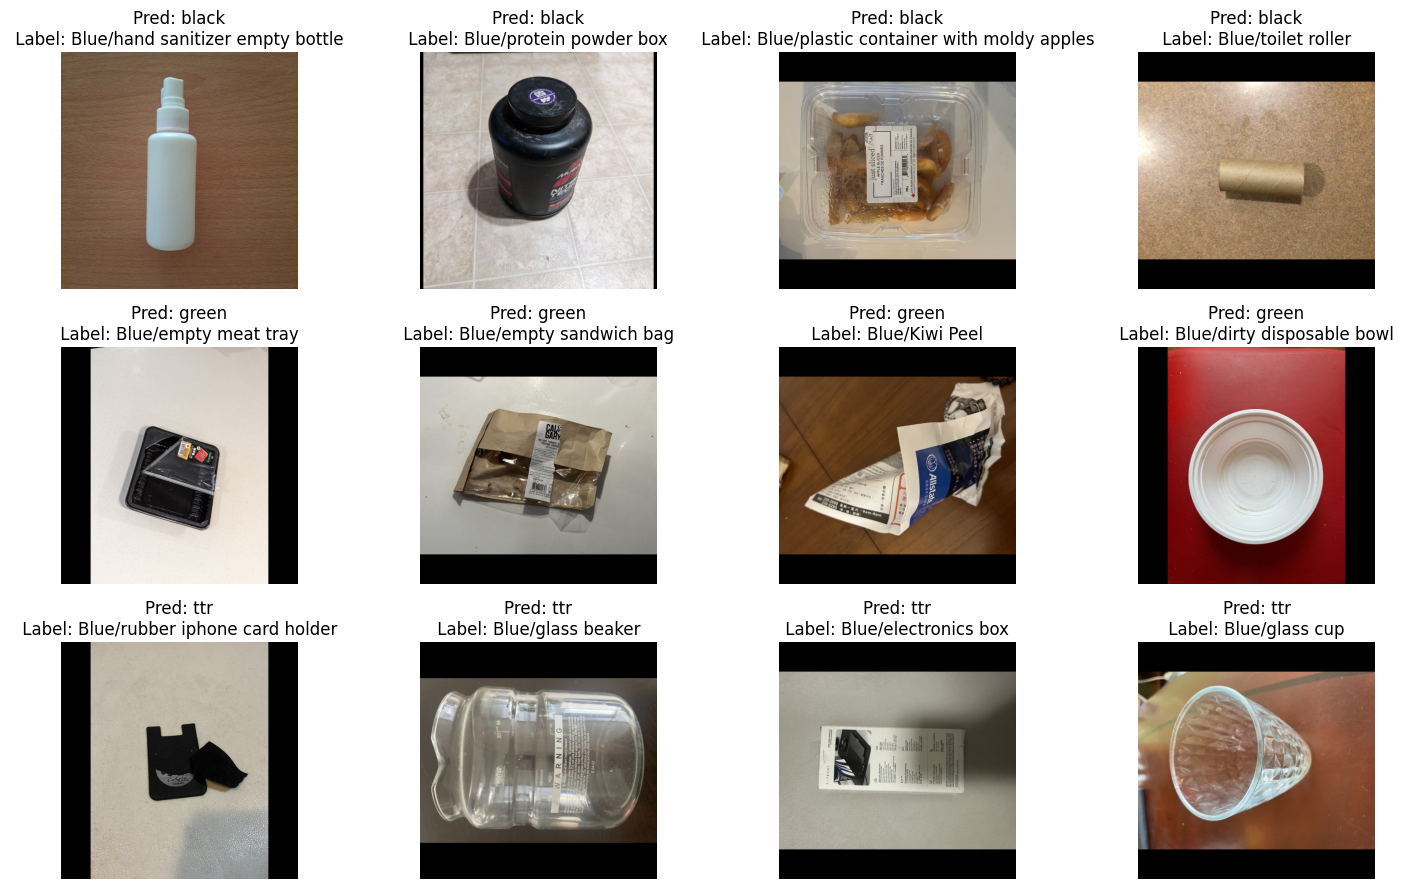

In [11]:
show_misclassified_examples(all_predictions, "blue")

***Misclassified Examples for the Landfill (Black) Class***

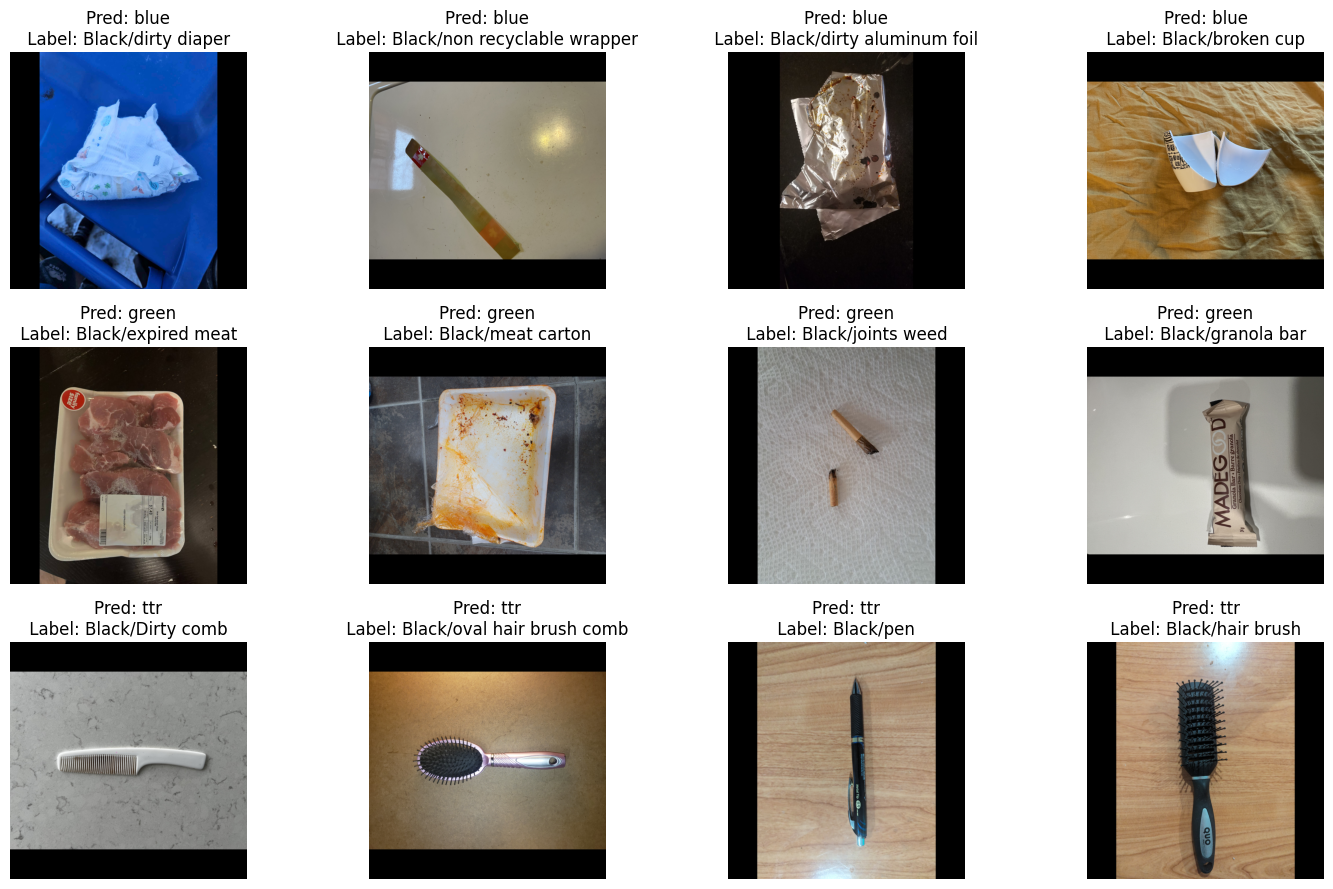

In [12]:
show_misclassified_examples(all_predictions, "black")


***Misclassified Examples for the Special Disposal (TTR) Class***

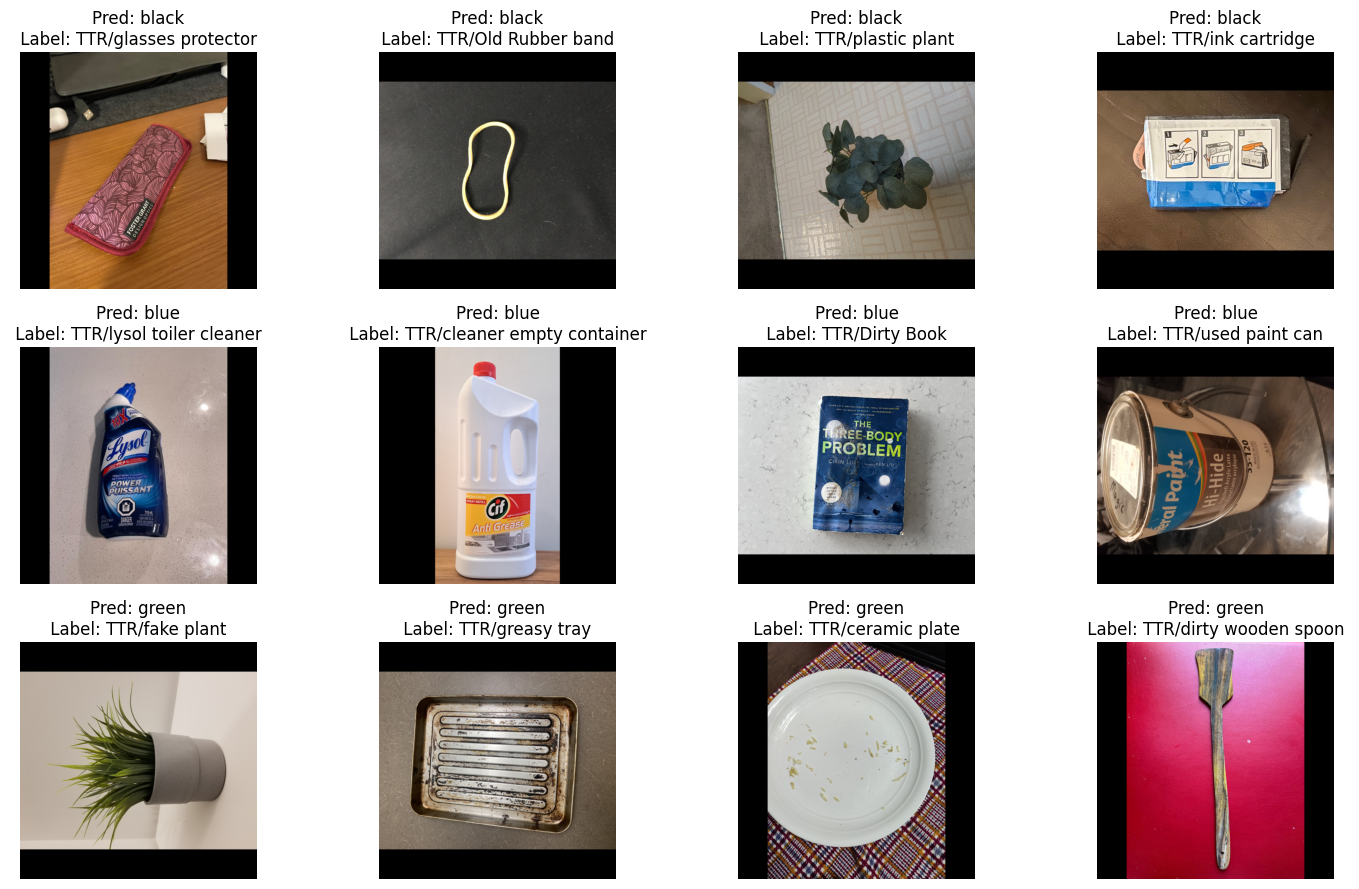

In [13]:
show_misclassified_examples(all_predictions, "ttr")

**"Out-of-domain" Predictions**

We observed that Paligemma occasionally made predictions that were outside the set of allowed options. Unfortunately (or fortunately), none of these were present when we made final predictions on the test set